### LASSO parameter range experiments

We want to see whether smaller models (i.e. models with fewer nonzero features) tend to generalize to new cancer types better than larger ones; this script compares/visualizes those results.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
base_results_dir = os.path.join(
    cfg.repo_root, '02_cancer_type_classification', 'results', 'lasso_poc'
)

training_dataset = 'all_other_cancers'
results_dir = os.path.join(base_results_dir, training_dataset)

### Get coefficient information for each lasso penalty

In [3]:
nz_coefs_df = []

# get pancancer coefs info for now
for coef_info in au.generate_nonzero_coefficients_lasso_range(results_dir):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
nz_coefs_df = pd.DataFrame(
    nz_coefs_df,
    columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
nz_coefs_df.head()

,gene,cancer_type,lasso_param,seed,fold,nz_coefs
0,TP53,SARC,0.005,1,0,1136
1,TP53,SARC,0.005,1,1,1228
2,TP53,SARC,0.005,1,2,970
3,TP53,SARC,0.005,1,3,1194
4,TP53,SARC,0.0005,1,0,3832


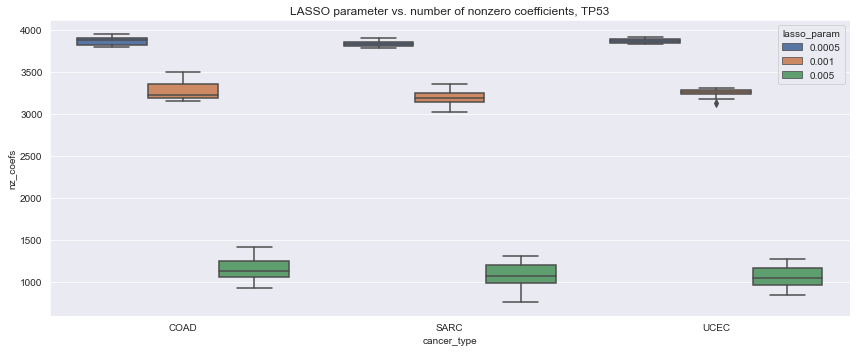

In [4]:
genes = ['TP53']

sns.set({'figure.figsize': (12, 5*len(genes))})
fig, axarr = plt.subplots(len(genes), 1)

for ix, gene in enumerate(genes):
    if len(genes) == 1:
        ax = axarr
    else:
        ax = axarr[ix]
    sns.boxplot(
        data=(
            nz_coefs_df[nz_coefs_df.gene == gene]
              .sort_values(by=['cancer_type', 'lasso_param'])
        ), x='cancer_type', y='nz_coefs', hue='lasso_param', ax=ax
    )
    ax.set_title(f'LASSO parameter vs. number of nonzero coefficients, {gene}')
plt.tight_layout()

### Get performance information for each lasso penalty

In [5]:
perf_df = au.load_prediction_results_lasso_range(results_dir, training_dataset)
perf_df.head()

,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,experiment,lasso_param
0,0.95027,0.93779,TP53,COAD,signal,1,train,0,all_other_cancers,0.005
1,0.88043,0.92397,TP53,COAD,signal,1,test,0,all_other_cancers,0.005
2,0.86936,0.84929,TP53,COAD,signal,1,cv,0,all_other_cancers,0.005
3,0.94117,0.92587,TP53,COAD,signal,1,train,1,all_other_cancers,0.005
4,0.88749,0.92042,TP53,COAD,signal,1,test,1,all_other_cancers,0.005


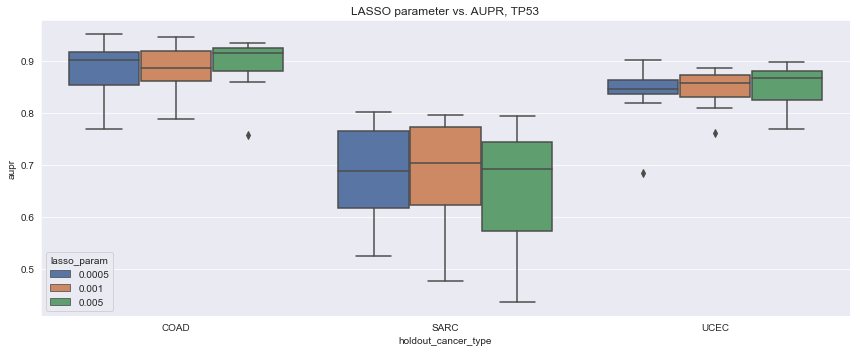

In [6]:
# genes = ['EGFR', 'ATRX', 'CDKN2A']
genes = ['TP53']
metric = 'aupr'

sns.set({'figure.figsize': (12, 5*len(genes))})
fig, axarr = plt.subplots(len(genes), 1)

for ix, gene in enumerate(genes):
    if len(genes) == 1:
        ax = axarr
    else:
        ax = axarr[ix]
    sns.boxplot(
        data=(
            perf_df[(perf_df.gene == gene) &
                    (perf_df.signal == 'signal') &
                    (perf_df.data_type == 'test')]
              .sort_values(by=['holdout_cancer_type', 'lasso_param'])
        ), x='holdout_cancer_type', y=metric, hue='lasso_param', ax=ax
    )
    ax.set_title(f'LASSO parameter vs. {metric.upper()}, {gene}')
plt.tight_layout()

### Compare feature selection with performance

In [7]:
coefs_perf_df = (nz_coefs_df
    .rename(columns={'cancer_type': 'holdout_cancer_type'})
    .merge(perf_df[perf_df.signal == 'signal'],
           on=['gene', 'holdout_cancer_type', 'seed', 'fold', 'lasso_param'])
    .drop(columns=['signal'])
)

coefs_perf_df.head()

,gene,holdout_cancer_type,lasso_param,seed,fold,nz_coefs,auroc,aupr,data_type,experiment
0,TP53,SARC,0.005,1,0,1136,0.93203,0.91633,train,all_other_cancers
1,TP53,SARC,0.005,1,0,1136,0.73153,0.73529,test,all_other_cancers
2,TP53,SARC,0.005,1,0,1136,0.87323,0.83045,cv,all_other_cancers
3,TP53,SARC,0.005,1,1,1228,0.94379,0.93062,train,all_other_cancers
4,TP53,SARC,0.005,1,1,1228,0.60099,0.60292,test,all_other_cancers


Text(0, 0.5, 'Holdout AUPR')

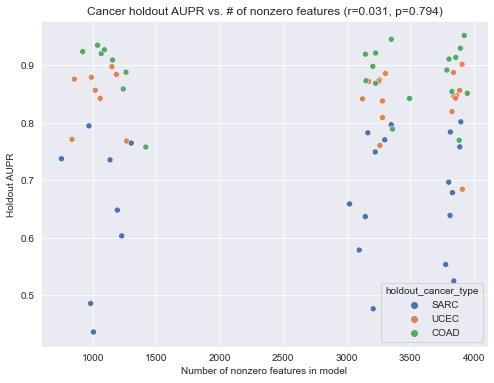

In [8]:
# plot test performance vs. number of nonzero features
sns.set({'figure.figsize': (8, 6)})

plot_df = coefs_perf_df[coefs_perf_df.data_type == 'test']
r, p = pearsonr(plot_df.nz_coefs.values, plot_df.aupr.values)

sns.scatterplot(data=plot_df, x='nz_coefs', y='aupr', hue='holdout_cancer_type')
plt.title('Cancer holdout AUPR vs. # of nonzero features (r={:.3f}, p={:.3f})'.format(r, p))
plt.xlabel('Number of nonzero features in model')
plt.ylabel('Holdout AUPR')

In [9]:
coefs_perf_pivot_df = coefs_perf_df.pivot(
    index=['gene', 'holdout_cancer_type', 'seed', 'fold', 'lasso_param', 'nz_coefs'],
    columns='data_type',
    values=['auroc', 'aupr']
)
coefs_perf_pivot_df.columns = ['_'.join(col).strip() for col in coefs_perf_pivot_df.columns.values]
coefs_perf_pivot_df.reset_index(inplace=True)

coefs_perf_pivot_df

,gene,holdout_cancer_type,seed,fold,lasso_param,nz_coefs,auroc_cv,auroc_test,auroc_train,aupr_cv,aupr_test,aupr_train
0,TP53,COAD,1,0,0.0005,3788,0.85806,0.87960,0.99492,0.83657,0.89186,0.99330
1,TP53,COAD,1,0,0.001,3151,0.85875,0.84197,0.98765,0.84701,0.87325,0.98323
2,TP53,COAD,1,0,0.005,921,0.86936,0.88043,0.95027,0.84929,0.92397,0.93779
3,TP53,COAD,1,1,0.0005,3858,0.87923,0.88120,0.99360,0.86792,0.91383,0.99204
4,TP53,COAD,1,1,0.001,3205,0.87169,0.87018,0.98572,0.86002,0.89840,0.98185
...,...,...,...,...,...,...,...,...,...,...,...,...
67,TP53,UCEC,42,2,0.001,3304,0.87869,0.91512,0.98332,0.83681,0.88592,0.98085
68,TP53,UCEC,42,2,0.005,1151,0.87629,0.91330,0.94190,0.81916,0.89778,0.93300
69,TP53,UCEC,42,3,0.0005,3857,0.86404,0.86326,0.99491,0.83497,0.84279,0.99412
70,TP53,UCEC,42,3,0.001,3124,0.86161,0.87083,0.98765,0.82585,0.84163,0.98645


Text(0, 0.5, 'Validation AUPR')

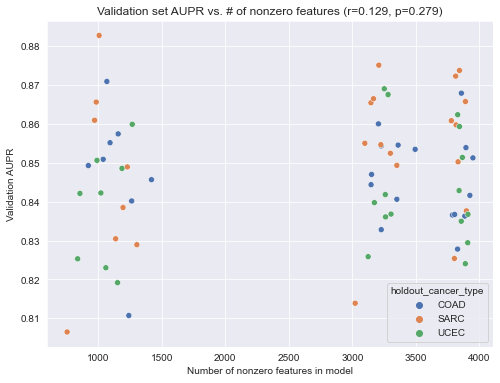

In [10]:
# plot validation performance vs. number of nonzero features
sns.set({'figure.figsize': (8, 6)})
r, p = pearsonr(coefs_perf_pivot_df.nz_coefs.values, coefs_perf_pivot_df.aupr_cv.values)

sns.scatterplot(data=coefs_perf_pivot_df, x='nz_coefs', y='aupr_cv', hue='holdout_cancer_type')
plt.title('Validation set AUPR vs. # of nonzero features (r={:.3f}, p={:.3f})'.format(r, p))
plt.xlabel('Number of nonzero features in model')
plt.ylabel('Validation AUPR')

Text(0, 0.5, '(Validation AUPR) / (Holdout AUPR)')

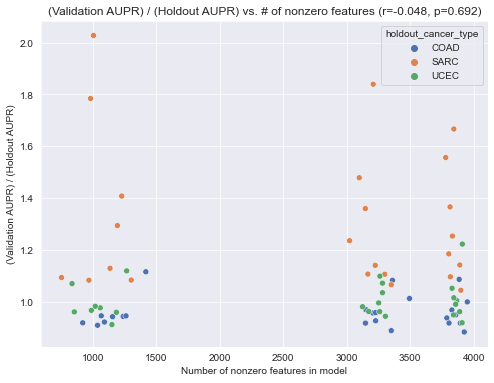

In [11]:
# plot validation performance vs. number of nonzero features
sns.set({'figure.figsize': (8, 6)})

coefs_perf_pivot_df['cv_test_aupr_ratio'] = (
    coefs_perf_pivot_df['aupr_cv']/ coefs_perf_pivot_df['aupr_test']
)
r, p = pearsonr(coefs_perf_pivot_df.nz_coefs.values, coefs_perf_pivot_df.cv_test_aupr_ratio.values)

sns.scatterplot(data=coefs_perf_pivot_df, x='nz_coefs', y='cv_test_aupr_ratio', hue='holdout_cancer_type')
plt.title('(Validation AUPR) / (Holdout AUPR) vs. # of nonzero features (r={:.3f}, p={:.3f})'.format(r, p))
plt.xlabel('Number of nonzero features in model')
plt.ylabel('(Validation AUPR) / (Holdout AUPR)')

For this limited set of genes/cancer types, there doesn't seem to be much of a relationship between model size and "performance", for any of these three ways of defining performance.

A better way to explore correlation between model size and performance might be to look at the partial correlation while controlling for cancer type - we'll explore this in the future.